In [40]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
import bokeh
import json
import us
import matplotlib.pyplot as plt
import seaborn as sns

from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import ColumnDataSource, figure, show, output_file
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar, NumeralTickFormatter, Slider, HoverTool, Select, Div
from bokeh.palettes import brewer

from bokeh.io.doc import curdoc
from bokeh.layouts import WidgetBox, row, column, gridplot

from bokeh.application import Application
from bokeh.application.handlers import FunctionHandler

from ipywidgets import interact, interact_manual, Dropdown, IntSlider
 
output_notebook()

Loading BokehJS ...

In [2]:
# set path
#path = r'C:/Users/ShrekTheOger/Documents/GitHub/final-project-final-project-bowen-and-natasia'
path = r'C:\Users\engel\Documents\GitHub\final-project-final-project-bowen-and-natasia'

## Read data
Read the data that we already cleaned. The data cleaning process and regression analysis could be found in separate py file. 

In [3]:
# read data

# data for income and population
df = os.path.join(path+'/refined_data', 'df_income_pop.csv')
df = pd.read_csv(df)

# data for the universities 
uni_df = os.path.join(path+'/refined_data', 'uni_fund_df.csv')
uni_df = pd.read_csv(uni_df)

In [4]:
# notes to bowen, I found more succinct solution to create GEOID
df['GEOID'] = df['COUNTYFIPS'].apply(lambda x: '{0:05}'.format(x))

In [5]:
#df.insert(3, 'GEOID', l)
df.drop(labels=['state_id', 'county_id'], axis=1, inplace = True)

In [6]:
df.head()

,year,state,county,COUNTYFIPS,total_population,total_native,total_born_in_state,total_born_out_state,total_born_outside_US,total_foreign_born,income_past12m,GEOID
0,2010,California,Merced County,6047,250699,188498,156434,29768,2296,62201,18041.0,06047
1,2010,California,Modoc County,6049,9605,8971,6067,2882,22,634,20536.0,06049
2,2010,California,Mono County,6051,13905,11341,7059,4108,174,2564,27321.0,06051
3,2010,California,Monterey County,6053,407435,284647,208218,69900,6529,122788,25776.0,06053
4,2010,California,Napa County,6055,134051,103891,73787,27759,2345,30160,34310.0,06055


# Retrive Shape file

In [7]:
#import warnings
#warnings.filterwarnings('ignore')

In [8]:
# https://www.census.gov/geographies/mapping-files/time-series/geo/cartographic-boundary.html
county_shp = os.path.join(path+'/raw_data', 'cb_2020_us_county_20m', 'cb_2020_us_county_20m.shp')
county = gpd.read_file(county_shp)

In [9]:
# Combine yearly data of county level income and population data with county geometries
df_shape = county.merge(df, how = 'inner', on='GEOID').set_geometry('geometry')

In [10]:
df_shape.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,NAMELSAD,STUSPS,STATE_NAME,LSAD,...,state,county,COUNTYFIPS,total_population,total_native,total_born_in_state,total_born_out_state,total_born_outside_US,total_foreign_born,income_past12m
0,01,061,00161556,0500000US01061,01061,Geneva,Geneva County,AL,Alabama,06,...,Alabama,Geneva County,1061,26541,26106,19062,6761,283,435,18351.0
1,01,061,00161556,0500000US01061,01061,Geneva,Geneva County,AL,Alabama,06,...,Alabama,Geneva County,1061,26646,26137,19078,6837,222,509,20120.0
2,01,061,00161556,0500000US01061,01061,Geneva,Geneva County,AL,Alabama,06,...,Alabama,Geneva County,1061,26769,26212,19186,6870,156,557,19393.0
3,01,061,00161556,0500000US01061,01061,Geneva,Geneva County,AL,Alabama,06,...,Alabama,Geneva County,1061,26791,26300,19037,7110,153,491,20199.0
4,01,061,00161556,0500000US01061,01061,Geneva,Geneva County,AL,Alabama,06,...,Alabama,Geneva County,1061,26816,26275,19115,6966,194,541,20027.0


In [11]:
#retrive shape file of universities
universities_shp = os.path.join(path+'/raw_data', 'Colleges_and_Universities-shp', 'Colleges_and_Universities.shp')
universities = gpd.read_file(universities_shp)

In [12]:
# merge university fund data with shape file university geometries
universities['IPEDSID'] = universities['IPEDSID'].astype(str).astype(int)
uni_shape = universities.merge(uni_df, how = 'inner', on = 'IPEDSID').set_geometry('geometry')
uni_shape = uni_shape.to_crs(df_shape.crs)

In [13]:
# filter unniversities that are the top universities
uni_filter = universities.loc[universities['IPEDSID'].isin(uni_df['IPEDSID'])].copy()
uni_filter = uni_filter[['IPEDSID', 'NAME', 'COUNTYFIPS']]

## Interactive Geographic Map Using Bokeh
Here we use Bokeh to display county level population information with hovering and display income discrepensies using density map. We also displayed where the top 50 universities at each state, also displaying their fund level using hovering effect.

Our code is heavily inspired by Jim King from his website https://jimking100.github.io/2019-09-04-Post-3/

In [14]:
def json_data(selectedYear, selectedState):
    yr = selectedYear
    st = selectedState
    # Pull selected year from state data
    df_yr = df_shape[(df_shape['year'] == yr) & (df_shape['state'] == st)].copy().reset_index(drop=True)
    
    merged_json = json.loads(df_yr.to_json())
    
    # Convert to json preferred string-like object 
    json_data = json.dumps(merged_json)
    return json_data

In [15]:
def json_data_uni(selectedYear, selectedState):
    yr = selectedYear
    st = selectedState
    # Pull selected year from state data
    uni_yr = uni_shape[(uni_shape['year'] == yr) & (uni_shape['state'] == st)].copy().reset_index(drop=True)
    merged_json = json.loads(uni_yr.to_json())
    
    # Convert to json preferred string-like object 
    json_data = json.dumps(merged_json)
    return json_data

In [16]:
"""The disadvantage of using a static scale is some county like Los Angelous has a overly dense population which pulled
the scale upper limit really high, so when we have state level inspections, many counties that have less than 100,000 become 
insignificant, even those big counties like Cook County become drawfted by the abnormal dense population from city like New 
York and Los Angeles."""


# This dictionary contains the formatting for the data in the plots
format_data = [('total_population', 0, 12000000,'0,0', 'Total Population'),
               ('total_native', 0, 6750000,'0,0', 'Total Native'),
               ('total_born_in_state', 0, 5200000,'0,0', 'Total Born in State'),
               ('total_born_out_state', 0, 2000000,'0,0', 'Total Born out State'),
               ('total_born_outside_us', 0, 130000,'0,0', 'Total Born out State'),
               ('total_foreign_born', 0, 3500000,'0,0', 'Total Foreigner'),
               ('income_past12m', 0, 80000,'$0,0', 'Income in Past 12 Months') 
              ]
 
#Create a DataFrame object from the dictionary 
format_df = pd.DataFrame(format_data, columns = ['field' , 'min_range', 'max_range' , 'format', 'verbage'])

In [17]:
# Define the callback function: update_plot
def update_plot(attr, old, new):
    # The input yr is the year selected from the slider
    yr = slider.value
    st = select_st.value
    new_data = json_data(yr, st)
    #new_uni = json_data_uni(yr, st)

    # The input cr is the criteria selected from the select box
    input_field = select.value
    input_field = format_df.loc[format_df['verbage'] == input_field, 'field'].iloc[0]
    
    # Update the plot based on the changed inputs
    p = make_plot(input_field)
    
    # Update the layout, clear the old document and display the new document
    layout = column(p, select, select_st, slider)
    curdoc().clear()
    curdoc().add_root(layout)

    # Update the data
    geosource.geojson = new_data
    #geosource_uni.geojson = new_uni

In [18]:
# Define the callback function: update_plot
def update_plot_uni(attr, old, new):
    # The input yr is the year selected from the slider
    yr = slider.value
    st = select_st.value
    new_uni = json_data_uni(yr, st)

    # Update the data
    geosource_uni.geojson = new_uni

In [19]:
# Create a plotting function
def make_plot(field_name):  
    # Set the format of the colorbar
    min_range = format_df.loc[format_df['field'] == field_name, 'min_range'].iloc[0]
    max_range = format_df.loc[format_df['field'] == field_name, 'max_range'].iloc[0]
    field_format = format_df.loc[format_df['field'] == field_name, 'format'].iloc[0]

    # Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
    color_mapper = LinearColorMapper(palette = palette, low = min_range, high = max_range)
    
    # Create color bar.
    format_tick = NumeralTickFormatter(format=field_format)
    color_bar = ColorBar(color_mapper=color_mapper, label_standoff=18, border_line_color=None, location = (0, 0))

    # Create figure object.
    verbage = format_df.loc[format_df['field'] == field_name, 'verbage'].iloc[0]

    p = figure(title = verbage, 
               plot_height = 650, plot_width = 850)
    
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    p.axis.visible = False

    # Add patch renderer to figure. 
    r1 = p.patches('xs','ys', source = geosource, fill_color = {'field' : field_name, 'transform' : color_mapper},
                   line_color = 'black', line_width = 0.25, fill_alpha = 1)

    # Specify color bar layout.
    p.add_layout(color_bar, 'right')

    # Add the hover tool to the graph
    p.add_tools(HoverTool(renderers=[r1], tooltips=hover))
    
    r2 = p.circle('x','y', color = 'red', source=geosource_uni, size=5, fill_alpha = 0.7)
    p.add_tools(HoverTool(renderers=[r2], tooltips=hover_uni))
    
    return p

In [20]:
# Input geojson source that contains features for plotting for:
# initial year 2010 and initial income per capital for counties -- Income_past12m

yr = slider.value
st = select_st.value
#geosource = GeoJSONDataSource(geojson = json_data(2015,'Illinois'))
#geosource_uni = GeoJSONDataSource(geojson = json_data_uni(2015,'Illinois'))
geosource = GeoJSONDataSource(geojson = json_data(yr,st))
geosource_uni = GeoJSONDataSource(geojson = json_data_uni(yr,st))
input_field = 'income_past12m'

# Define a sequential multi-hue color palette.
palette = brewer['Blues'][8]

# Reverse color order so that dark blue is highest obesity.
palette = palette[::-1]

# Add hover tool

hover = [ ('County','@NAME'),('State', '@state'),('Total population', '@total_population{,}'),
         ('Born instate', '@total_born_in_state{,}'),('Born outstate', '@total_born_out_state{,}'),]
hover_uni = [ ('School','@NAME'),('Fund', '@fund{,}')]

# Make a slider object: slider 
slider = Slider(title = 'Year',start = 2010, end = 2019, step = 1, value = 2015)


# Make a selection object: select
select = Select(title='Select Criteria:', value='income_past12m', options=['Income in Past 12 Months', 'Total Population'])

# Make a selection object: select
select_st = Select(title='Select Target State:', value='Illinois', options=uni_shape['state'].unique().tolist())

# Call the plotting function
p = make_plot(input_field)

# Make a column layout of widgetbox(slider) and plot, and add it to the current document
# Display the current document
layout = column(p, select, select_st, slider)


def modify_doc(doc):
    doc.add_root(column(layout))
    slider.on_change('value', update_plot)
    select.on_change('value', update_plot)
    select_st.on_change('value', update_plot)
    slider.on_change('value', update_plot_uni)
    select.on_change('value', update_plot_uni)
    select_st.on_change('value', update_plot_uni)
    
handler = FunctionHandler(modify_doc)
app = Application(handler)
show(app)

# Natasia is working on this part


In [21]:
# all data: university fund, population, and income
# matched university fund data with the population and income data in that county
all_data = uni_df.merge(uni_filter, how = 'inner', on = ['IPEDSID'])
all_data['year'] = all_data['year'].astype(float)
all_data['COUNTYFIPS'] = all_data['COUNTYFIPS'].astype(float)

all_data = all_data.merge(df_shape, how = 'inner', on=['year', 'state', 'COUNTYFIPS'])

In [22]:
# group fund by country FIPS
# this is to find out how big is the fund for each county
fund_county = all_data.groupby(['year','COUNTYFIPS','state', 'county','total_population', 
                                'total_native', 'total_born_in_state','total_born_out_state',
                                'total_born_outside_US','total_foreign_born','income_past12m'])['fund'].sum().reset_index()

fund_county['year'] = fund_county['year'].astype(int) 

In [23]:
uni_state = fund_county['state'].unique()

# create dictionary for ipwidget 
options = {state: all_data.loc[all_data['state'] == state, 'county'].unique().tolist() for state in uni_state}

In [24]:
#variables = ['Total Born in State', 'Total Born out State', 'Total Born outside US', 
#             'Total Foreigner', 'Income in Past 12 Month']

variables = ['Total Born in State', 'Total Born out State', 'Total Born outside US', 'Total Foreigner']
# create widget
first_widget = Dropdown(options=options.keys())
second_widget = Dropdown()
third_widget= Dropdown(options=variables)

In [25]:
# This dictionary contains the formatting for the data in the plots
format_data = [('total_born_in_state', 0, 1,'0,0', 'Total Born in State'),
               ('total_born_out_state', 0, 1,'0,0', 'Total Born out State'),
               ('total_born_outside_US', 0, 1,'0,0', 'Total Born outside US'),
               ('total_foreign_born', 0, 1,'0,0', 'Total Foreigner'),
               ('income_past12m', 0, 100000,'$0,0', 'Income in Past 12 Months')]
 
#Create a DataFrame object from the dictionary 
format_df = pd.DataFrame(format_data, columns = ['field' , 'min_range', 'max_range' , 'format', 'verbage'])

In [26]:
def data_plot_pop(state, county, variable):
    df_filter = fund_county[(fund_county['state']==state) & (fund_county['county']==county)]
    
    data_plot = pd.DataFrame()
    data_plot['year'] = df_filter['year']
    data_plot[variable] = (df_filter[variable]/df_filter['total_population'])
    data_plot = data_plot.sort_values('year', ascending = True).reset_index(drop=True)
    
    return data_plot 

In [27]:
def data_plot_income(state, county):
    df_filter = fund_county[(fund_county['state']==state) & (fund_county['county']==county)]
    
    data_plot = pd.DataFrame()
    data_plot['year'] = df_filter['year']
    data_plot['income_past12m'] = df_filter['income_past12m']
    data_plot['fund'] = df_filter['fund']
    data_plot = data_plot.sort_values('year', ascending = True).reset_index(drop=True)
    
    return data_plot 

In [28]:
def plot_line_pop(variable, source): 
    var_title = format_df.loc[format_df['field'] == variable, 'verbage'].iloc[0]
    tool = [('value', '@'+variable+'{0.0000}'), ('year','@year')]
    plot = figure(title=f'Share of Total Population: {var_title}', x_axis_label='Year', y_axis_label='natural units', 
                  tooltips=tool, plot_height=400)
    
    r = plot.line(x='year', y=variable , source=source, color='blue')
    r = plot.circle(x='year', y=variable , source=source, color='grey')
    
    return plot

In [29]:
def plot_line_income(source): 
    tool = [('value', '@income_past12m'), ('year','@year')]
    plot = figure(title="Income in Past 12 Months", x_axis_label='Year', y_axis_label='in USD', 
                  tooltips=tool, plot_height=400)
    
    r = plot.line(x='year', y='income_past12m', source=source, color='green')
    r = plot.circle(x='year', y='income_past12m', source=source, color='grey')
    
    plot.yaxis.formatter = NumeralTickFormatter(format="$0")
    
    return plot

In [30]:
def plot_line_fund(source): 
    tool = [('value', '@fund'), ('year','@year')]
    plot = figure(title="R&D Fund", x_axis_label='Year', y_axis_label='in USD', 
                  tooltips=tool, plot_height=400)
    
    r = plot.line(x='year', y='fund', source=source, color='magenta')
    r = plot.circle(x='year', y='fund', source=source, color='grey')
    
    plot.yaxis.formatter = NumeralTickFormatter(format="$0")
    
    return plot

In [31]:
# https://docs.bokeh.org/en/latest/docs/user_guide/data.html
def update(*args):
    second_widget.options = options[first_widget.value]

first_widget.observe(update)

initial_data = data_plot_pop('Michigan', 'Washtenaw County', 'total_born_outside_US')
source = ColumnDataSource(data=initial_data)

plot = plot_line_pop('total_born_outside_US', source)

def update_plot(state, county, variable):
    var = format_df.loc[format_df['verbage'] == variable, 'field'].iloc[0]
    update_data = data_plot_pop(state, county, var)
    source = ColumnDataSource(data=update_data)
    plot = plot_line_pop(var, source)
    
    show(plot)
interact(update_plot, state=first_widget, county=second_widget, variable=third_widget);

interactive(children=(Dropdown(description='state', options=('Alabama', 'Arizona', 'California', 'Colorado', '…

In [32]:
# https://docs.bokeh.org/en/latest/docs/user_guide/data.html
# https://docs.bokeh.org/en/latest/docs/first_steps/first_steps_4.html

def update(*args):
    second_widget.options = options[first_widget.value]

first_widget.observe(update)
initial_data = data_plot_income('Michigan', 'Washtenaw County')

source = ColumnDataSource(data=initial_data)

# plot income 
plot_income = plot_line_income(source)

# plot fund
plot_fund = plot_line_fund(source)

def update_plot_income(state, county):
    update_data = data_plot_income(state, county)
    #source = ColumnDataSource(data=update_data)
    source.data = update_data
    
    show(column(plot_income, plot_fund))
interact(update_plot_income, state=first_widget, county=second_widget);

interactive(children=(Dropdown(description='state', options=('Alabama', 'Arizona', 'California', 'Colorado', '…

## Create Static Plot

In [33]:
# function to generate color
def color_gen(n):
    palette = bokeh.palettes.cividis(n)
    for color in palette:
        yield color

In [34]:
# create plot with multiple lines
def plot_multiline(df, xaxis, yaxis, hue, title):
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 10)
    sns.set_theme(style='whitegrid')
    
    graph = sns.lineplot(data=df, x=xaxis, y=yaxis, hue=hue, style=hue, markers=True);
    graph.legend(loc='center left', bbox_to_anchor=(1.00, 0.5), ncol=1);
    graph.set(title=title, ylabel='natural units');
    
    return graph

In [46]:
fund_county['share_foreigner'] = (fund_county['total_foreign_born']/fund_county['total_population'])

In [47]:
fund_county

,year,COUNTYFIPS,state,county,total_population,total_native,total_born_in_state,total_born_out_state,total_born_outside_US,total_foreign_born,income_past12m,fund,share_foreigner
0,2010,1073.0,Alabama,Jefferson County,656912,630177,498814,127742,3621,26735,26529.0,509668.0,0.040698
1,2010,4019.0,Arizona,Pima County,964462,836971,369134,453395,14442,127491,25093.0,610387.0,0.132189
2,2010,6001.0,California,Alameda County,1477980,1022541,729291,274106,19144,455439,33961.0,722136.0,0.308150
3,2010,6037.0,California,Los Angeles County,9758256,6280433,4714216,1475093,91124,3477823,27344.0,1591693.0,0.356398
4,2010,6073.0,California,San Diego County,3022468,2323982,1421078,850452,52452,698486,30715.0,981389.0,0.231098
...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,2019,48453.0,Texas,Travis County,1226805,1008677,640756,346529,21392,218128,43658.0,619710.0,0.177802
436,2019,49035.0,Utah,Salt Lake County,1133646,987997,666691,308974,12332,145649,33238.0,535157.0,0.128478
437,2019,51121.0,Virginia,Montgomery County,98140,90512,52356,36819,1337,7628,30054.0,482486.0,0.077726
438,2019,53033.0,Washington,King County,2195502,1687926,867365,780048,40513,507576,52462.0,1269137.0,0.231189


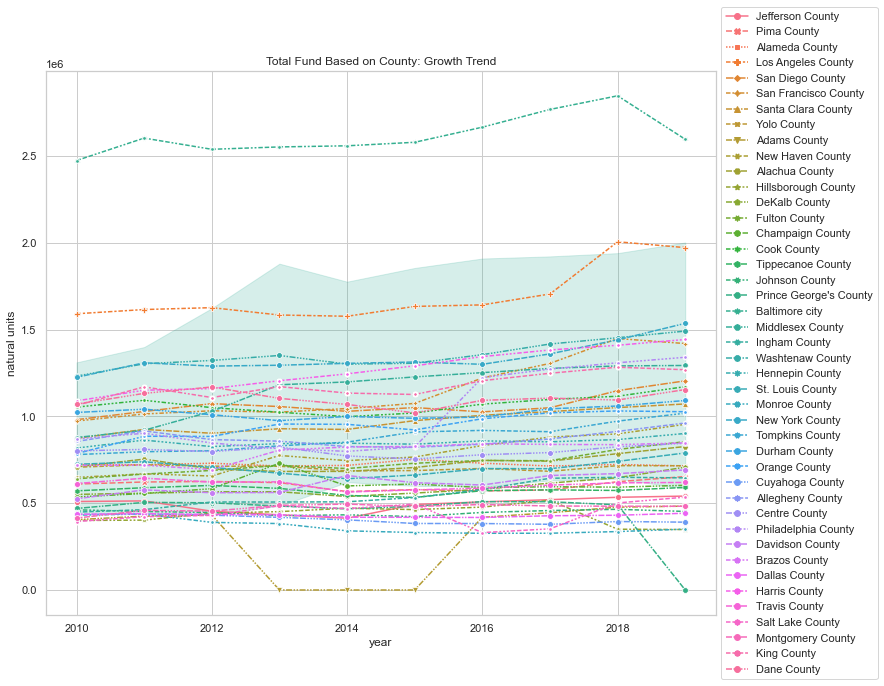

In [44]:
plot_multiline(fund_county, 'year', 'fund', 'county', 'Total Fund Based on County: Growth Trend');

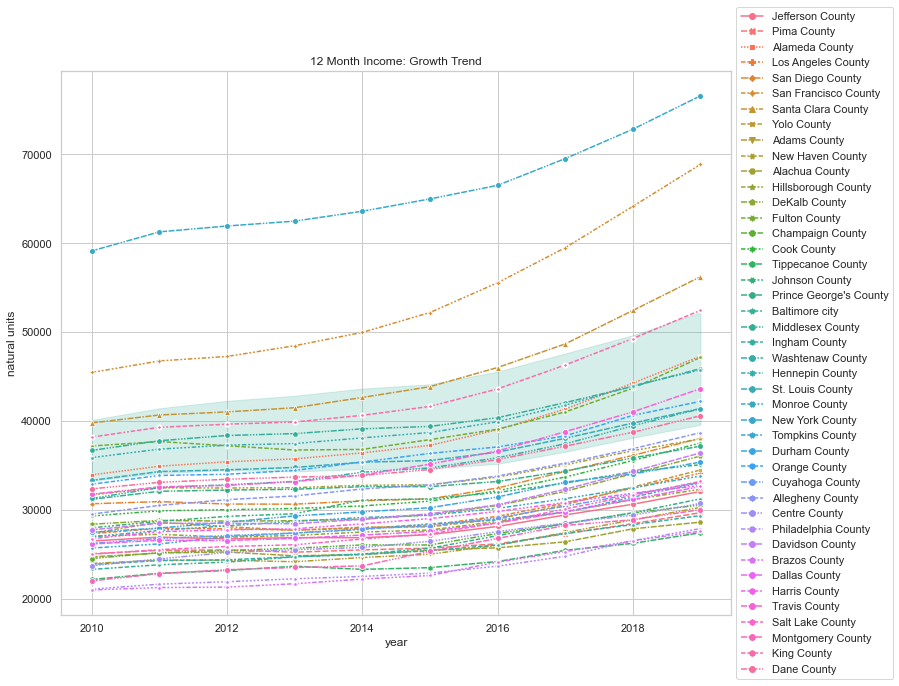

In [43]:
plot_multiline(fund_county, 'year', 'income_past12m', 'county', '12 Month Income: Growth Trend');

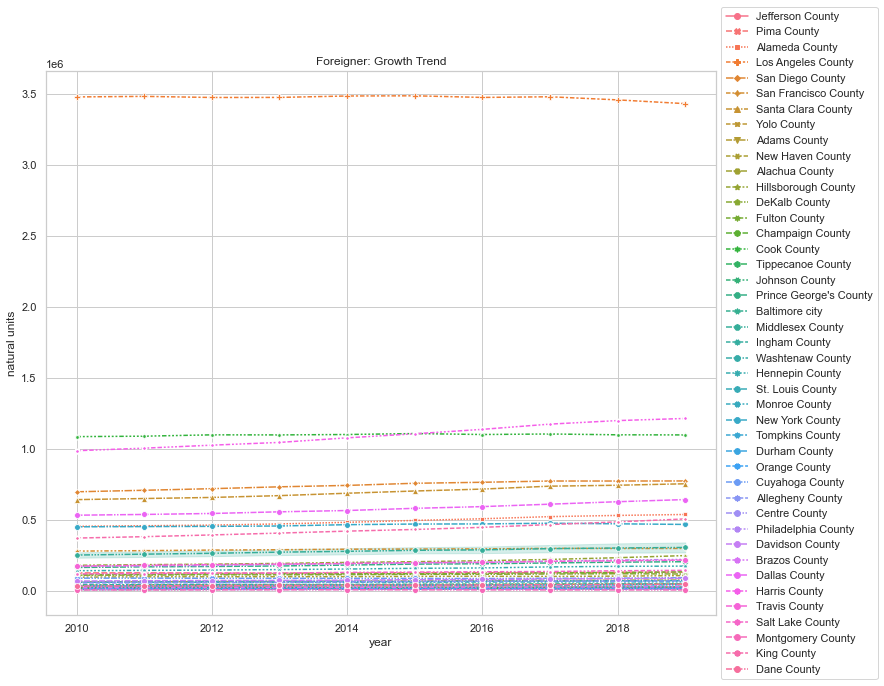

In [45]:
plot_multiline(fund_county, 'year', 'total_foreign_born', 'county', 'Foreigner: Growth Trend');

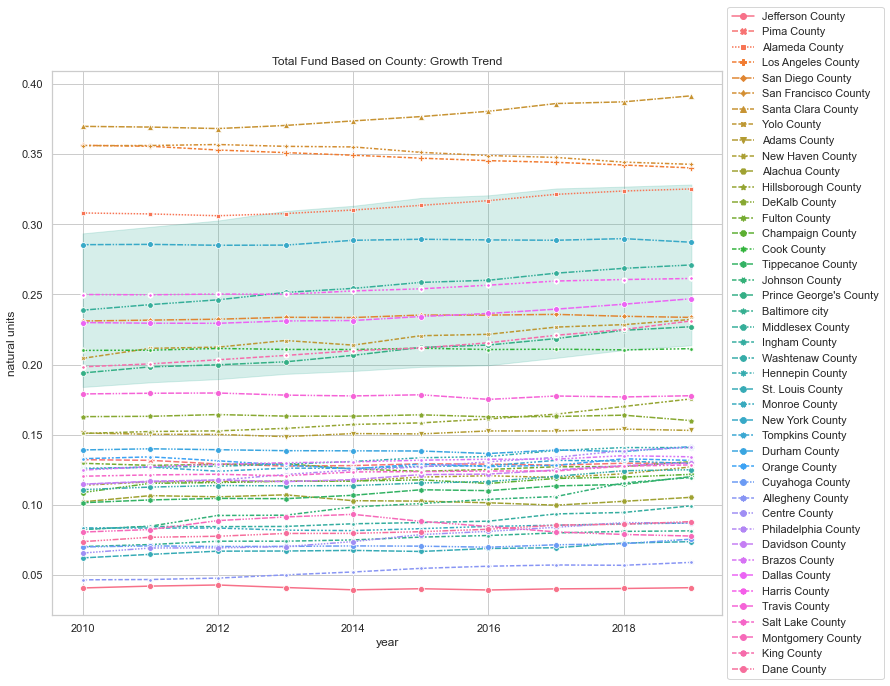

In [48]:
plot_multiline(fund_county, 'year', 'share_foreigner', 'county', 'Total Fund Based on County: Growth Trend');